In [2]:
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, RobertaTokenizer, AutoModel
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import ast
import Levenshtein
from torch.serialization import safe_globals

In [3]:
# # Load the test dataset (expected target outputs)
# with open("../../dataset/data/python/processed_with_verdict/test.jsonl", "r") as file:
#     test_data = [json.loads(line) for i, line in enumerate(file) if i < 10]
test_data = []
# Load the test dataset (expected target outputs)
# with open("../../dataset/data/python/processed_with_verdict/test.jsonl", "r") as file:
#     for i, line in enumerate(file):
#         # print(line)
#         test_data.append(json.loads(line))
#         if i == 10:
#             break

with open("../../dataset/data/python/processed_with_verdict/test.jsonl", "r", encoding="utf-8") as f:
    data = json.load(f)  # Load all data at once
# print(data)
preprocessed_data = []

for i, entry in enumerate(data):
    print(entry)
    if i >= 10:
        break
    preprocessed_data.append(entry)

test_data = preprocessed_data
# print(test_data)

{'src_id': 'p02547_s853646132', 'src': ['N', '=', 'int', '(', 'input', '(', ')', ')', 'NEW_LINE', 'z', ',', 'w', '=', '[', ']', ',', '[', ']', 'NEW_LINE', 'K', '=', '0', 'NEW_LINE', 'for', 'i', 'in', 'range', '(', 'N', ')', ':', 'NEW_LINE', 'INDENT', 'x', ',', 'y', '=', 'map', '(', 'int', ',', 'input', '(', ')', '.', 'split', '(', ')', ')', 'NEW_LINE', 'z', '.', 'append', '(', 'x', ')', 'NEW_LINE', 'w', '.', 'append', '(', 'y', ')', 'NEW_LINE', 'DEDENT', 'for', 'j', 'in', 'range', '(', '1', ',', 'N', '-', '1', ')', ':', 'NEW_LINE', 'INDENT', 'if', 'z', '[', 'j', ']', '==', 'w', '[', 'j', ']', 'and', 'z', '[', 'j', '+', '1', ']', '==', 'w', '[', 'j', '+', '1', ']', 'and', 'z', '[', 'j', '+', '2', ']', '==', 'w', '[', 'j', '+', '2', ']', ':', 'NEW_LINE', 'INDENT', 'K', '+=', '1', 'NEW_LINE', 'DEDENT', 'DEDENT', 'if', 'K', '>=', '1', ':', 'NEW_LINE', 'INDENT', 'print', '(', '" Yes "', ')', 'NEW_LINE', 'DEDENT', 'else', ':', 'NEW_LINE', 'INDENT', 'print', '(', '" No "', ')', 'NEW_LINE', 'D

In [ ]:
print((preprocessed_data))

# test_data = [preprocessed_data[0]]

[{'src_id': 'p02547_s853646132', 'src': ['N', '=', 'int', '(', 'input', '(', ')', ')', 'NEW_LINE', 'z', ',', 'w', '=', '[', ']', ',', '[', ']', 'NEW_LINE', 'K', '=', '0', 'NEW_LINE', 'for', 'i', 'in', 'range', '(', 'N', ')', ':', 'NEW_LINE', 'INDENT', 'x', ',', 'y', '=', 'map', '(', 'int', ',', 'input', '(', ')', '.', 'split', '(', ')', ')', 'NEW_LINE', 'z', '.', 'append', '(', 'x', ')', 'NEW_LINE', 'w', '.', 'append', '(', 'y', ')', 'NEW_LINE', 'DEDENT', 'for', 'j', 'in', 'range', '(', '1', ',', 'N', '-', '1', ')', ':', 'NEW_LINE', 'INDENT', 'if', 'z', '[', 'j', ']', '==', 'w', '[', 'j', ']', 'and', 'z', '[', 'j', '+', '1', ']', '==', 'w', '[', 'j', '+', '1', ']', 'and', 'z', '[', 'j', '+', '2', ']', '==', 'w', '[', 'j', '+', '2', ']', ':', 'NEW_LINE', 'INDENT', 'K', '+=', '1', 'NEW_LINE', 'DEDENT', 'DEDENT', 'if', 'K', '>=', '1', ':', 'NEW_LINE', 'INDENT', 'print', '(', '" Yes "', ')', 'NEW_LINE', 'DEDENT', 'else', ':', 'NEW_LINE', 'INDENT', 'print', '(', '" No "', ')', 'NEW_LINE', '

In [31]:
import io
import tokenize

def tokenize_code(code):
    tokens = []
    try:
        g = tokenize.generate_tokens(io.StringIO(code).readline)
        for toknum, tokval, _, _, _ in g:
            if toknum != tokenize.ENCODING:
                tokens.append(tokval)
    except Exception:
        pass  # fallback or skip
    return tokens


In [41]:
def safe_compile(code):
    try:
        compile(code, "<string>", "exec")
        return True
    except Exception:
        return False

def ast_similarity(code1, code2):
    try:
        tree1 = ast.dump(ast.parse(code1))
        tree2 = ast.dump(ast.parse(code2))
        return Levenshtein.ratio(tree1, tree2)
    except Exception:
        return 0.0

def evaluate_bugfix(predictions, ground_truths):
    assert len(predictions) == len(ground_truths), "Mismatch in predictions and ground truths"

    total = len(predictions)
    exact_matches = 0
    compile_success = 0
    total_lev_distance = 0
    total_ast_similarity = 0
    bleu_scores = []

    smooth_fn = SmoothingFunction().method1

    for pred, gt in zip(predictions, ground_truths):
        # Ensure pred and gt are strings, not lists
        if isinstance(pred, list):
            pred = " ".join(pred)  # Join the list into a single string
        if isinstance(gt, list):
            gt = " ".join(gt)  # Join the list into a single string

        # Now strip the strings
        if pred.strip() == gt.strip():
            exact_matches += 1

        # Compilation
        if safe_compile(pred):
            compile_success += 1

        # Levenshtein (normalized)
        lev_dist = Levenshtein.distance(pred, gt)
        total_lev_distance += lev_dist / max(len(gt), 1)

        # AST Similarity
        total_ast_similarity += ast_similarity(pred, gt)

        # BLEU
        reference = [tokenize_code(gt)]
        hypothesis = tokenize_code(pred)
        bleu = sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

    # Normalizing each metric to ensure they are between 0 and 1
    results = {
        "Exact Match Accuracy": (exact_matches / total),
        "Compilation Success Rate": compile_success / total,
        "Average Normalized Levenshtein Distance": total_lev_distance / total,
        "Average AST Similarity": total_ast_similarity / total,
        "Average BLEU Score": sum(bleu_scores) / total
    }

    return results


In [42]:
def detokenize(tokens):
    code = []
    indent_level = 0
    i = 0

    no_space_before = {')', ']', '}', '.', ',', ':', '(', '[', '{', '"'}
    no_space_after = {'(', '[', '{', '"', '.'}

    while i < len(tokens):
        token = tokens[i]

        if token == 'NEW_LINE':
            code.append('\n')
        elif token == 'INDENT':
            indent_level += 1
        elif token == 'DEDENT':
            indent_level = max(indent_level - 1, 0)
        elif token in {'for', 'if'}:
            code.append('\n ')
            code.append('    ' * indent_level)
            code.append(token)
        else:
            if not code or code[-1].endswith('\n'):
                code.append('    ' * indent_level)

            if code and not code[-1].endswith('\n') and token not in no_space_before and code[-1] not in no_space_after:
                code.append(' ')

            code.append(token)

        i += 1

    return ''.join(code)

In [ ]:
def evaluate_seq2seq(model, tokenizer, max_length=128):
    predictions = []
    ground_truths = []
    
    for entry in test_data:
        # print(entry)
        src_code = entry["src"]
        expected_output = entry["tgt"]

        # Tokenize input with attention_mask explicitly passed
        inputs = tokenizer(
            src_code,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        # print("buggy code:", src_code)
        with torch.no_grad():
            output = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128
            )

        predicted_code = tokenizer.decode(output[0], skip_special_tokens=True)
        # print("p\n", predicted_code, '\n\ne\n', expected_output)
        expected_output = detokenize(expected_output)
        # print("p\n", predicted_code, '\n\ne\n', expected_output)
        predictions.append(predicted_code)
        ground_truths.append(expected_output)
        # print("Input:\n", src_code)
        # print("\nOutput:\n", predicted_code)
        # print("\nExpected Output:\n", expected_output)
        
    return evaluate_bugfix(predictions, ground_truths)


In [ ]:
def evaluate_codet5(model, tokenizer, max_length=128):
    predictions = []
    ground_truths = []
    
    for entry in test_data:
        print(entry)
        src_code = entry["src"]
        expected_output = entry["tgt"]
        src_code = detokenize(src_code)
        src_code = "Refine:\n" + src_code

        # Tokenize input with attention_mask explicitly passed
        inputs = tokenizer(
            src_code,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        # print("buggy code:", src_code)
        
        with torch.no_grad():
            output = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128
            )

        predicted_code = tokenizer.decode(output[0], skip_special_tokens=True)
        expected_output = detokenize(expected_output)
        # print("p\n", predicted_code, '\n\ne\n', expected_output)
        predictions.append(predicted_code)
        ground_truths.append(expected_output)
        # print("Input:\n", src_code)
        # print("\nOutput:\n", predicted_code)
        # print("\nExpected Output:\n", expected_output)
        
    return evaluate_bugfix(predictions, ground_truths)


In [44]:
import re

def cleanup_tokens(token_str):
    # Normalize whitespace
    token_str = token_str.replace('\n', ' ').replace('\r', ' ')
    token_str = re.sub(r'\s+', ' ', token_str).strip()

    # Split into tokens
    tokens = token_str.split()
    cleaned = []

    # Valid operators and keywords
    valid_symbols = {
        "NEW_LINE", "INDENT", "DEDENT",
        "(", ")", "[", "]", "{", "}", ":", ",", ".", "+", "-", "*", "/", "=", "==", "!=", "<", ">", "<=", ">=", ":=", '"'
    }

    garbage_start_index = None

    for i, token in enumerate(tokens):
        # Detect garbage start: long runs of repeated tokens
        if token in {"=", "_", "+", "-", "[", "]"} and i + 3 < len(tokens):
            # Check if a repeated pattern begins (like '= = = =')
            pattern = tokens[i:i+5]
            if all(p == token for p in pattern):
                garbage_start_index = i
                break

    # Clean only the part before the garbage starts
    if garbage_start_index is not None:
        tokens = tokens[:garbage_start_index]

    # Now keep only valid tokens
    for token in tokens:
        if token in valid_symbols:
            cleaned.append(token)
        elif token in {"NEW_LINE", "INDENT", "DEDENT"}:
            cleaned.append(token)
        elif re.fullmatch(r"[a-zA-Z_][a-zA-Z0-9_]*", token):  # identifiers/keywords
            cleaned.append(token)
        elif re.fullmatch(r"\d+", token):  # numbers
            cleaned.append(token)
        # else: skip

    # Move last valid token to start (if we had garbage and tokens are present)
    if cleaned:
        last_valid = cleaned[-1]
        if last_valid not in {"NEW_LINE", "INDENT", "DEDENT"}:
            cleaned.pop()
            cleaned.insert(0, last_valid)

    return " ".join(cleaned)


In [45]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class CodeErrorFixModel(nn.Module):
    def __init__(self, encoder_model_name, vocab_size, embed_size=768, num_decoder_layers=6, nhead=8):
        super().__init__()
        # Load the pretrained CodeBERT encoder
        self.encoder = AutoModel.from_pretrained(encoder_model_name)
        # Decoder components
        self.decoder_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dropout=0.1)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.embed_size = embed_size
    
    def generate_square_subsequent_mask(self, sz):
        # Create a mask to ensure that each position only attends to previous positions
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)
    
    def forward(self, src_input_ids, src_attention_mask, tgt_input_ids, tgt_attention_mask):
        # Encode source sequence
        encoder_outputs = self.encoder(input_ids=src_input_ids, attention_mask=src_attention_mask)
        memory = encoder_outputs.last_hidden_state  # shape: (batch_size, src_seq_len, embed_size)
        
        # Prepare target embeddings
        tgt_embeddings = self.decoder_embedding(tgt_input_ids) * math.sqrt(self.embed_size)
        tgt_embeddings = self.pos_encoder(tgt_embeddings)
        # Transformer expects (seq_len, batch_size, embed_size)
        tgt_embeddings = tgt_embeddings.transpose(0, 1)
        memory = memory.transpose(0, 1)
        
        tgt_seq_len = tgt_input_ids.size(1)
        # Create target mask for auto-regressive generation
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)
        
        decoder_output = self.decoder(tgt=tgt_embeddings, memory=memory, tgt_mask=tgt_mask)
        # Transpose back: (batch_size, seq_len, embed_size)
        decoder_output = decoder_output.transpose(0, 1)
        logits = self.fc_out(decoder_output)  # (batch_size, seq_len, vocab_size)
        return logits

def encode_example(example, tokenizer, max_length=512):
    src_tokens = example['src']
    tgt_tokens = example['tgt']
    src_text = " ".join(src_tokens)
    
    # Add start and end tokens to the target
    tgt_text = "<s> " + " ".join(tgt_tokens) + " </s>"
    
    src_enc = tokenizer(src_text, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
    tgt_enc = tokenizer(tgt_text, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
    return src_enc, tgt_enc

def pre_tokenize_data(data, tokenizer, max_length=512):
    tokenized_data = []
    src_enc, tgt_enc = encode_example(data, tokenizer, max_length)
    tokenized_data.append({
        'src_input_ids': src_enc['input_ids'].squeeze(0),
        'src_attention_mask': src_enc['attention_mask'].squeeze(0),
        'tgt_input_ids': tgt_enc['input_ids'].squeeze(0),
        'tgt_attention_mask': tgt_enc['attention_mask'].squeeze(0)
    })
    return tokenized_data

In [46]:
def evaluate_custom(model, tokenizer, device='cpu'):
    model.eval()
    model.to(device)

    predictions = []
    ground_truths = []

    for entry in test_data:
        tokenized_test_data = pre_tokenize_data(entry, tokenizer, max_length=512)
        test_loader = DataLoader(tokenized_test_data, batch_size=1)
        
        with torch.no_grad():
            for batch in test_loader:
                src_input_ids = batch['src_input_ids'].to(device)
                src_attention_mask = batch['src_attention_mask'].to(device)
                tgt_input_ids = batch['tgt_input_ids'].to(device)
                tgt_attention_mask = batch['tgt_attention_mask'].to(device)

                # 🔮 Predict (use teacher forcing)
                output = model(src_input_ids, src_attention_mask, tgt_input_ids[:, :-1], tgt_attention_mask[:, :-1])
                predicted_ids = output.argmax(dim=-1)

                # Decode Input (buggy), Prediction, and Target (ground truth)
                input_text = tokenizer.decode(src_input_ids[0], skip_special_tokens=True)
                predicted_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
                target_text = tokenizer.decode(tgt_input_ids[0], skip_special_tokens=True)
        
        predicted_text = cleanup_tokens(predicted_text)
        predicted_text = detokenize(predicted_text.split())
      
        target_text = detokenize(target_text.split())
        
        predictions.append(predicted_text)
        ground_truths.append(target_text)
        
    return evaluate_bugfix(predictions, ground_truths)

In [59]:
accuracy = []
compilation = []
lev_distance = []
ast_score = []
bleu = []

In [60]:
model_path = "Salesforce/codeT5-base"  # Path to your saved model folder
print("----------------------- CodeT5 --------------------")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
codeT5_result = evaluate_codet5(model, tokenizer)
print(f"Results: {codeT5_result}")  

accuracy.append(codeT5_result["Exact Match Accuracy"])
compilation.append(codeT5_result["Compilation Success Rate"])
lev_distance.append(codeT5_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeT5_result["Average AST Similarity"])
bleu.append(codeT5_result["Average BLEU Score"])

model_path = "../../codebert-custom0/full_model.pth"  # Path to your saved model folder
print("----------------------- CodeBERT-Custom0 --------------------")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = torch.load(model_path, map_location="cpu", weights_only=False)
codeBERTcustom_result = evaluate_custom(model, tokenizer)
print(f"Average BLEU Score: {codeBERTcustom_result}")

accuracy.append(codeBERTcustom_result["Exact Match Accuracy"])
compilation.append(codeBERTcustom_result["Compilation Success Rate"])
lev_distance.append(codeBERTcustom_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTcustom_result["Average AST Similarity"])
bleu.append(codeBERTcustom_result["Average BLEU Score"])

model_path = "../../codebert-custom1/full_model.pth"  # Path to your saved model folder
print("----------------------- CodeBERT-Custom1 --------------------")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = torch.load(model_path, map_location="cpu", weights_only=False)
codeBERTcustom_result = evaluate_custom(model, tokenizer)
print(f"Average BLEU Score: {codeBERTcustom_result}")

accuracy.append(codeBERTcustom_result["Exact Match Accuracy"])
compilation.append(codeBERTcustom_result["Compilation Success Rate"])
lev_distance.append(codeBERTcustom_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTcustom_result["Average AST Similarity"])
bleu.append(codeBERTcustom_result["Average BLEU Score"])

model_path = "../../codebert-custom2/full_model.pth"  # Path to your saved model folder
print("----------------------- CodeBERT-Custom2 --------------------")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = torch.load(model_path, map_location="cpu", weights_only=False)
codeBERTcustom_result = evaluate_custom(model, tokenizer)
print(f"Average BLEU Score: {codeBERTcustom_result}")

accuracy.append(codeBERTcustom_result["Exact Match Accuracy"])
compilation.append(codeBERTcustom_result["Compilation Success Rate"])
lev_distance.append(codeBERTcustom_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTcustom_result["Average AST Similarity"])
bleu.append(codeBERTcustom_result["Average BLEU Score"])

model_path = "../../codebert-custom3/full_model.pth"  # Path to your saved model folder
print("----------------------- CodeBERT-Custom3 --------------------")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = torch.load(model_path, map_location="cpu", weights_only=False)
codeBERTcustom_result = evaluate_custom(model, tokenizer)
print(f"Average BLEU Score: {codeBERTcustom_result}")

accuracy.append(codeBERTcustom_result["Exact Match Accuracy"])
compilation.append(codeBERTcustom_result["Compilation Success Rate"])
lev_distance.append(codeBERTcustom_result["Average Normalized Levenshtein Distance"])
ast_score.append(codeBERTcustom_result["Average AST Similarity"])
bleu.append(codeBERTcustom_result["Average BLEU Score"])

----------------------- CodeT5 --------------------
{'src_id': 'p02547_s853646132', 'src': ['N', '=', 'int', '(', 'input', '(', ')', ')', 'NEW_LINE', 'z', ',', 'w', '=', '[', ']', ',', '[', ']', 'NEW_LINE', 'K', '=', '0', 'NEW_LINE', 'for', 'i', 'in', 'range', '(', 'N', ')', ':', 'NEW_LINE', 'INDENT', 'x', ',', 'y', '=', 'map', '(', 'int', ',', 'input', '(', ')', '.', 'split', '(', ')', ')', 'NEW_LINE', 'z', '.', 'append', '(', 'x', ')', 'NEW_LINE', 'w', '.', 'append', '(', 'y', ')', 'NEW_LINE', 'DEDENT', 'for', 'j', 'in', 'range', '(', '1', ',', 'N', '-', '1', ')', ':', 'NEW_LINE', 'INDENT', 'if', 'z', '[', 'j', ']', '==', 'w', '[', 'j', ']', 'and', 'z', '[', 'j', '+', '1', ']', '==', 'w', '[', 'j', '+', '1', ']', 'and', 'z', '[', 'j', '+', '2', ']', '==', 'w', '[', 'j', '+', '2', ']', ':', 'NEW_LINE', 'INDENT', 'K', '+=', '1', 'NEW_LINE', 'DEDENT', 'DEDENT', 'if', 'K', '>=', '1', ':', 'NEW_LINE', 'INDENT', 'print', '(', '" Yes "', ')', 'NEW_LINE', 'DEDENT', 'else', ':', 'NEW_LINE', '

[0.0, 0.0, 0.0, 0.0, 0.0]


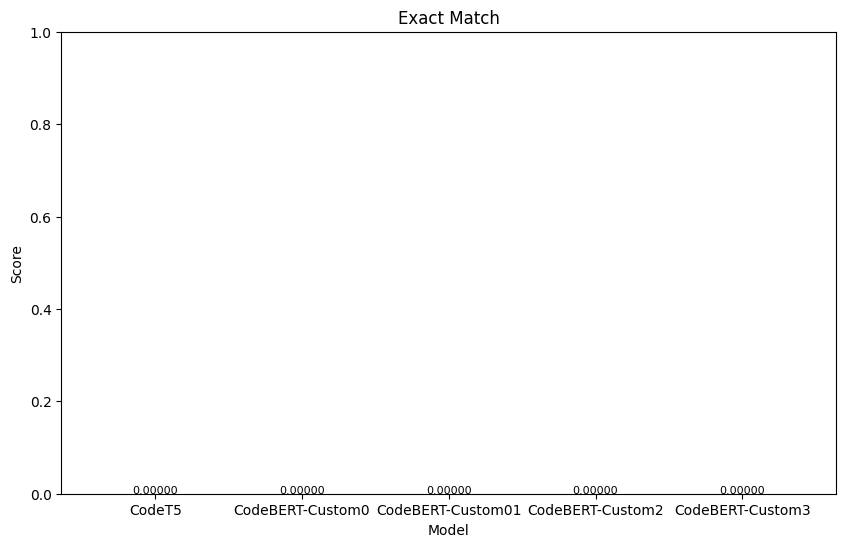

[1.0, 0.0, 0.0, 0.0, 0.0]


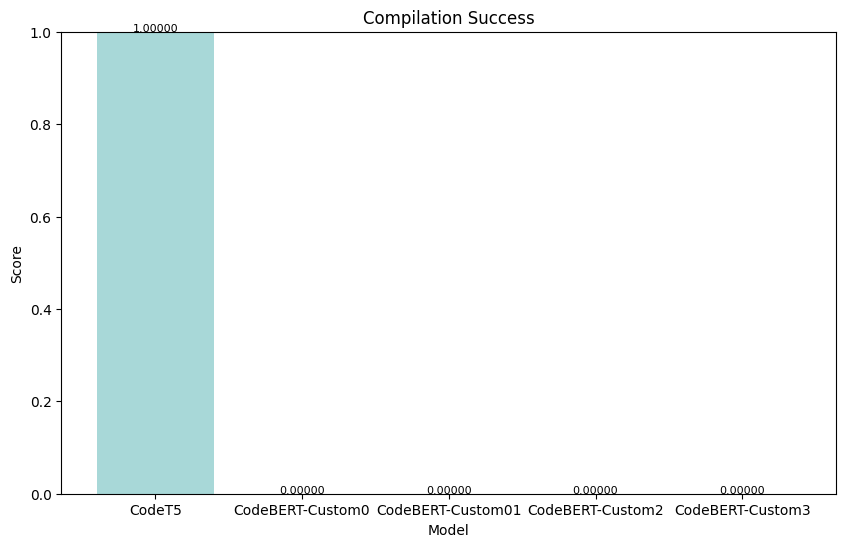

[0.9835526315789473, 0.03333333333333333, 0.03666666666666667, 0.04666666666666667, 0.04]


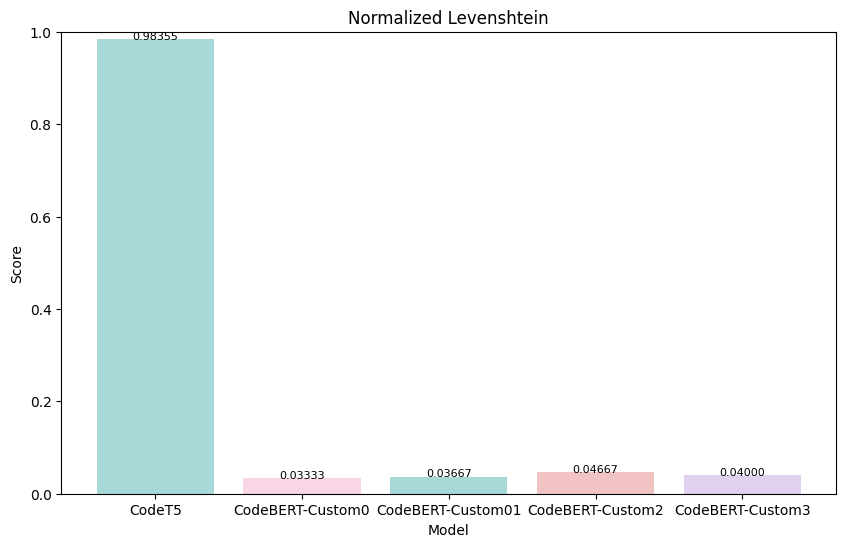

[0.0, 0.0, 0.0, 0.0, 0.0]


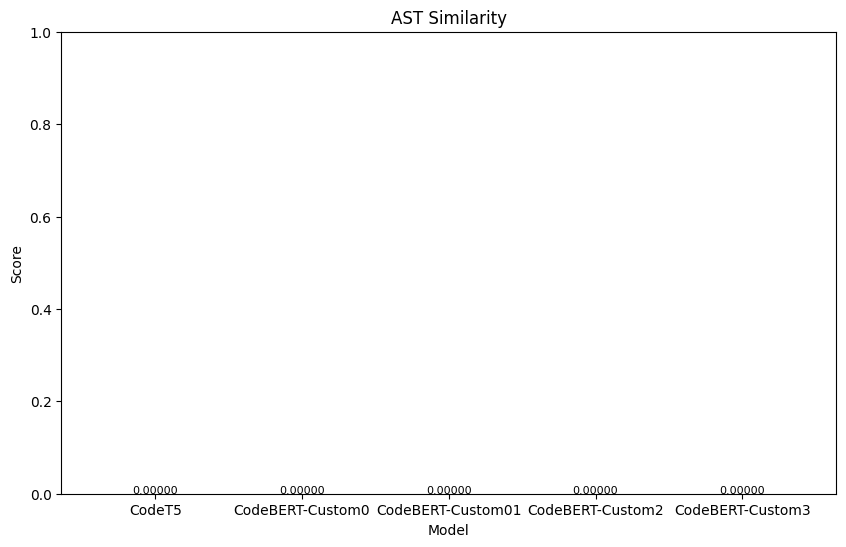

[1.4371742968188917e-14, 0.928870241685825, 0.703222936547737, 0.898878758843829, 0.9257584048521668]


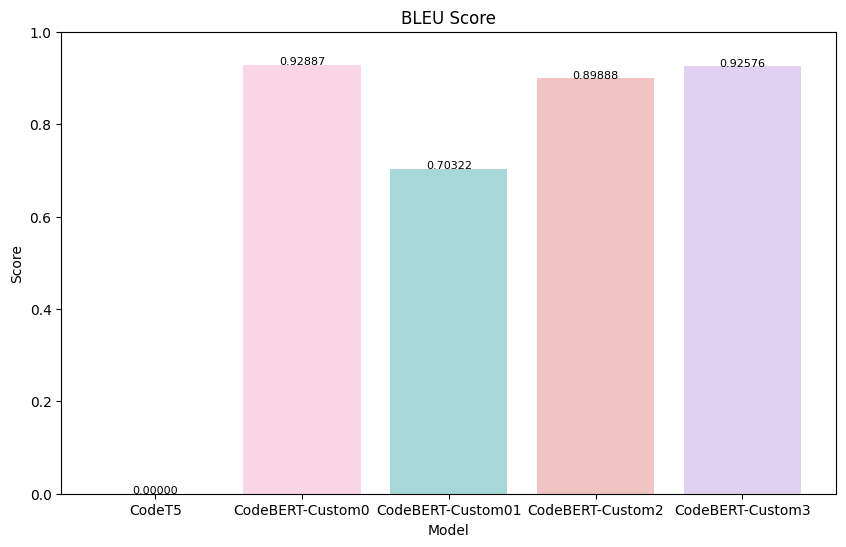

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and metric values
models = ['CodeT5', 'CodeBERT-Custom0', 'CodeBERT-Custom01', 'CodeBERT-Custom2', 'CodeBERT-Custom3']

# Consistent model-specific colors
model_colors = ['#A8D8D8', '#F9D5E5', '#A7D7D7', '#F2C3C3', '#E1D1F1']  # You can customize these

def plot_metric(metric, title):
    print(metric)
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric, color=model_colors)
    
    padding = (max(metric) - min(metric)) * 0.1
    # if "Compilation" in title:
    #     plt.ylim(0, 1)
    # elif "Lev" in title:
    #     plt.ylim(0, 13)
    # else:
    plt.ylim(0, 1)

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(title)

    for i, val in enumerate(metric):
        plt.text(i, val, f'{val:.5f}', ha='center', fontsize=8)
    
    plt.show()

# Plot each metric using the shared function
plot_metric(accuracy, 'Exact Match')
plot_metric(compilation, 'Compilation Success')
plot_metric(lev_distance, 'Normalized Levenshtein')
plot_metric(ast_score, 'AST Similarity')
plot_metric(bleu, 'BLEU Score')
